In [2]:
%pylab inline
import cv2
import numpy as np
import dicom
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/home/ulisses/miniconda3/envs/amb1/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


# Load some data for exploration

In [3]:
img_001 = cv2.imread('referenceData/MIAS/raw_data/mdb001.pgm', cv2.IMREAD_UNCHANGED)
print (img_001.shape)
print (img_001.dtype)

AttributeError: 'NoneType' object has no attribute 'shape'

In [3]:
print img_001.mean()
print img_001.std()
print img_001.max()
print img_001.min()

36.5348396301
63.4198780802
221
0


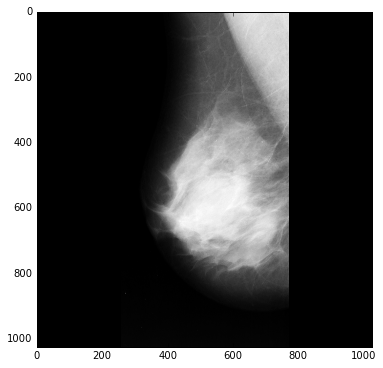

In [4]:
fig,ax = subplots()
fig.set_size_inches([6, 6])
ax.imshow(img_001, cmap='gray')

In [5]:
img_info_df = pd.read_csv('referenceData/MIAS/raw_data/mammogram_info.csv', sep=" ")
img_info_df.head()

,Reference,Bkg,Class,Sever,X,Y,Rad
0,mdb001,G,CIRC,B,535,425,197.0
1,mdb002,G,CIRC,B,522,280,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477,133,30.0


In [6]:
img_malign_df = img_info_df.loc[img_info_df['Sever'] == 'M']
print img_malign_df.shape
img_malign_df.head()

(54, 7)


,Reference,Bkg,Class,Sever,X,Y,Rad
23,mdb023,G,CIRC,M,538,681,29.0
28,mdb028,F,CIRC,M,338,314,56.0
58,mdb058,D,MISC,M,318,359,27.0
72,mdb072,G,ASYM,M,266,517,28.0
75,mdb075,F,ASYM,M,468,717,23.0


In [7]:
img_info_df['Rad'].describe()

/home/lishen/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


count    119.000000
mean      48.848739
std       33.558863
min        3.000000
25%             NaN
50%             NaN
75%             NaN
max      197.000000
Name: Rad, dtype: float64

In [8]:
img_malign_df['Rad'].describe()

count     51.000000
mean      56.705882
std       32.435964
min       13.000000
25%             NaN
50%             NaN
75%             NaN
max      174.000000
Name: Rad, dtype: float64

In [9]:
img_info_df['Bkg'].describe()

count     330
unique      3
top         D
freq      117
Name: Bkg, dtype: object

# Draw ROI

In [10]:
img_info_df_indexed = img_info_df.set_index('Reference')
img_info_df_indexed.head()

,Bkg,Class,Sever,X,Y,Rad
Reference,,,,,,
mdb001,G,CIRC,B,535,425,197.0
mdb002,G,CIRC,B,522,280,69.0
mdb003,D,NORM,NaN,NaN,NaN,NaN
mdb004,D,NORM,NaN,NaN,NaN,NaN
mdb005,F,CIRC,B,477,133,30.0


In [11]:
img_001_info = img_info_df_indexed.loc['mdb001']
img_001_info

Bkg         G
Class    CIRC
Sever       B
X         535
Y         425
Rad       197
Name: mdb001, dtype: object

In [12]:
x1 = int(img_001_info['X']) - int(img_001_info['Rad'])
y1 = 1024 - int(img_001_info['Y']) - int(img_001_info['Rad'])
x2 = int(img_001_info['X']) + int(img_001_info['Rad'])
y2 = 1024 - int(img_001_info['Y']) + int(img_001_info['Rad'])
print x1, y1
print x2, y2

338 402
732 796


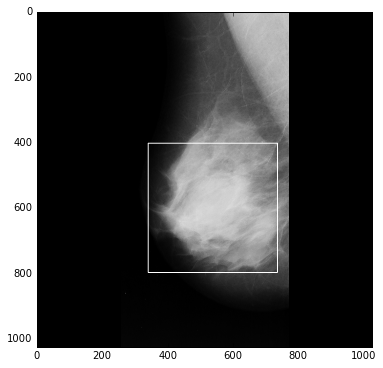

In [13]:
# cv2.imshow(img_001)
img_001_rect = cv2.rectangle(img_001, (x1, y1), (x2, y2), (255,255,255), 2)
fig,ax = subplots()
fig.set_size_inches([6, 6])
ax.imshow(img_001_rect, cmap='gray')

In [14]:
rad = img_info_df_indexed['Rad'].copy()
rad.sort_values(ascending=True).head(10)

Reference
mdb212     3.0
mdb223     6.0
mdb226     7.0
mdb218     8.0
mdb226     8.0
mdb227     9.0
mdb248    10.0
mdb214    11.0
mdb211    13.0
mdb236    14.0
Name: Rad, dtype: float64

In [15]:
rad = img_info_df_indexed['Rad'].copy()
rad.sort_values(ascending=False).head(10)

Reference
mdb001    197.0
mdb148    174.0
mdb193    132.0
mdb081    131.0
mdb274    123.0
mdb115    117.0
mdb184    114.0
mdb107    111.0
mdb111    107.0
mdb105     98.0
Name: Rad, dtype: float64

In [16]:
print sum(img_info_df_indexed['Class'] == 'NORM')
print sum(img_info_df_indexed['Class'] != 'NORM')

207
123


In [17]:
def show_roi(ref, folder, df, r=None, n=0):
    from os import path
    img = cv2.imread(path.join(folder, ref + '.pgm'), cv2.IMREAD_UNCHANGED)
    info = df.loc[ref]
    try:
        xc = int(info['X'])
        yc = int(info['Y'])
        if r is None:
            r = int(info['Rad'])
    except TypeError:
        xc = int(info['X'].iloc[n])
        yc = int(info['Y'].iloc[n])
        if r is None:
            r = int(info['Rad'].iloc[n])
    x1 = xc - r
    y1 = 1024 - yc - r
    x2 = xc + r
    y2 = 1024 - yc + r
    
    img_roi = cv2.rectangle(img, (x1, y1), (x2, y2), (255,255,255), 2)
    fig,ax = subplots()
    fig.set_size_inches([9, 9])
    ax.imshow(img_roi, cmap='gray')

In [18]:
int(img_info_df_indexed.loc['mdb144']['X'].iloc[0])

233

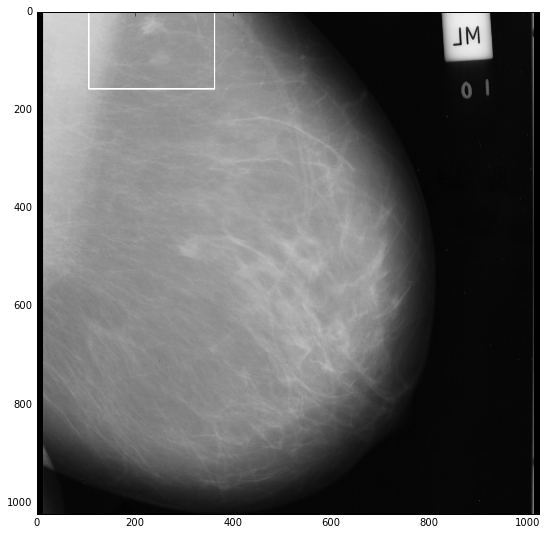

In [19]:
show_roi('mdb144', 'referenceData/MIAS/raw_data/', img_info_df_indexed, 128, n=0)

In [99]:
from os import path
rs = 128  # ROI radius size.
roi_cnt = 0
outdir = 'referenceData/MIAS/roi'

def clip(v, minv=0, maxv=1024):
    v = minv if v < minv else v
    v = maxv if v > maxv else v
    return v
    
for ref, info in img_info_df_indexed.iterrows():
    try:
        xc = int(info['X'])
        yc = int(info['Y'])
        r = int(info['Rad'])
    except ValueError:
        continue
    img = cv2.imread(path.join('referenceData/MIAS/raw_data/', ref + '.pgm'), cv2.IMREAD_UNCHANGED)
    if r <= rs:
        x = xc - rs
        x = clip(x)
        y = 1024 - yc - rs
        y = clip(y)
        roi = img[y:y+rs*2, x:x+rs*2]
        patch = np.zeros((rs*2, rs*2))
        patch[0:roi.shape[0], 0:roi.shape[1]] = roi
        fn = "%s_roi%04d.png" % (ref, roi_cnt)
        cv2.imwrite(path.join(outdir, fn), patch, [cv2.IMWRITE_PNG_COMPRESSION, 0])
        roi_cnt += 1
    else:
        # When the ROI radius is larger than 128, 
        # extract all 9 patches that are centered 
        # around the ROI center.
        xss = [-r, -rs, r-2*rs]
        yss = [-r, -rs, r-2*rs]
        for xs in xss:
            for ys in yss:
                x = xc + xs
                x = clip(x)
                y = 1024 - yc + ys
                y = clip(y)
                roi = img[y:y+rs*2, x:x+rs*2]
                patch = np.zeros((rs*2, rs*2))
                patch[0:roi.shape[0], 0:roi.shape[1]] = roi
                fn = "%s_roi%04d.png" % (ref, roi_cnt)
                cv2.imwrite(path.join(outdir, fn), patch, [cv2.IMWRITE_PNG_COMPRESSION, 0])
                roi_cnt += 1
print roi_cnt

151


## Show the 9 patches for a large ROI

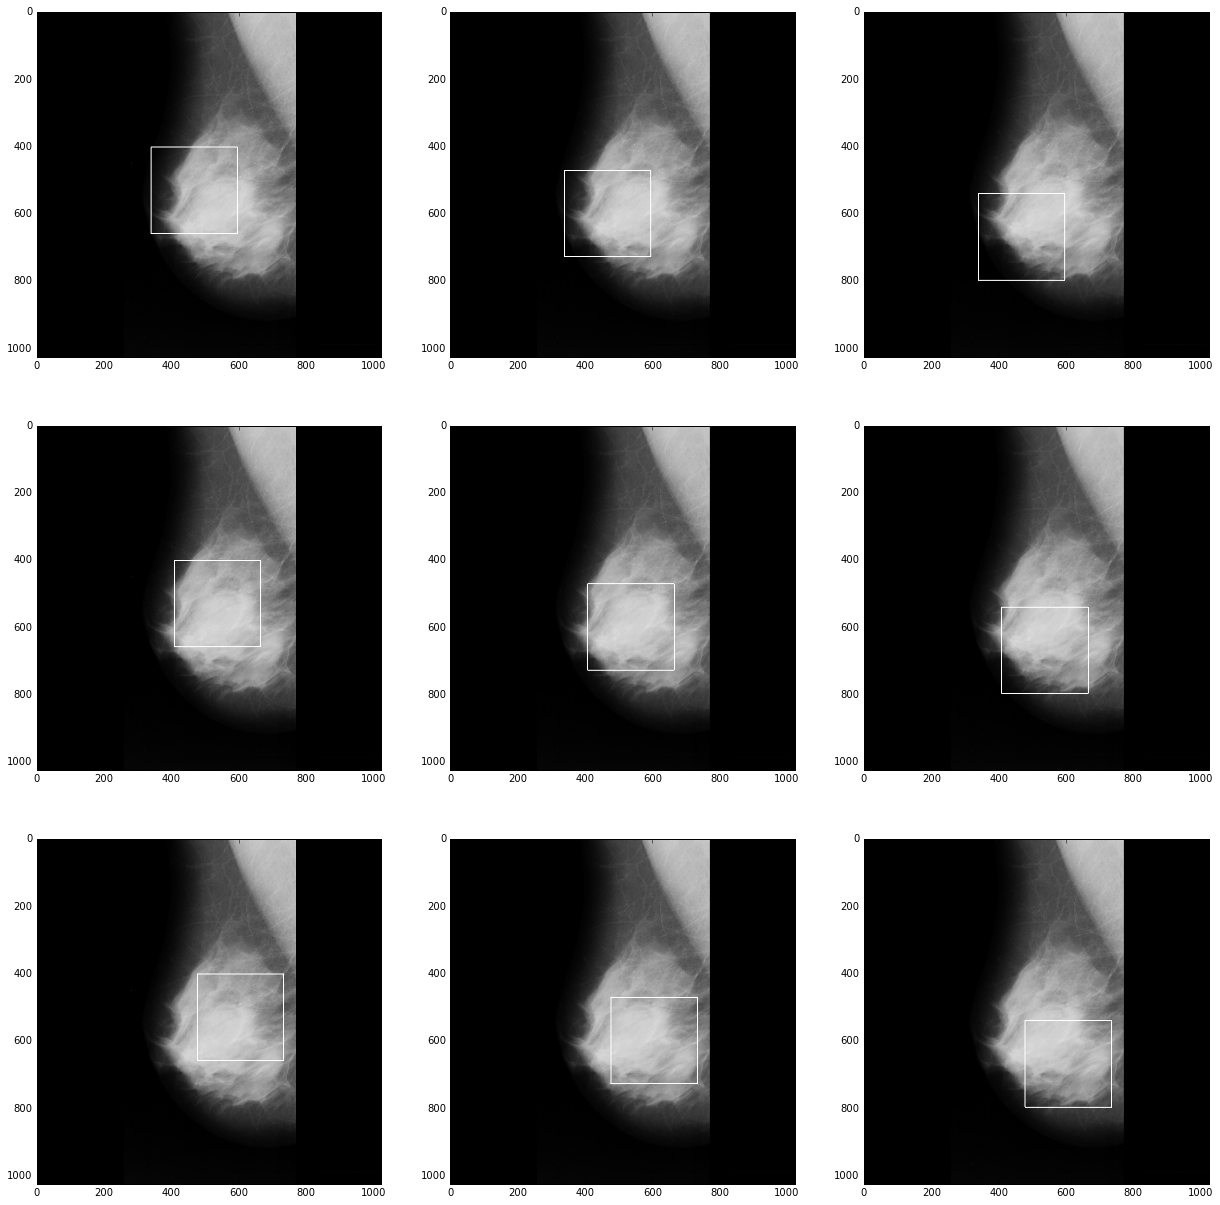

In [21]:
from os import path

fig,axes = subplots(3, 3)
fig.set_size_inches([21, 21])
rs = 128  # ROI radius size.
info = img_info_df_indexed.loc['mdb001']
try:
    xc = int(info['X'])
    yc = int(info['Y'])
    r = int(info['Rad'])
except ValueError:
    pass
img = cv2.imread(path.join('referenceData/MIAS/raw_data/', 'mdb001' + '.pgm'), cv2.IMREAD_UNCHANGED)
xss = [-r, -rs, r-2*rs]
yss = [-r, -rs, r-2*rs]
for i, xs in enumerate(xss):
    for j, ys in enumerate(yss):
        x = xc + xs
        y = 1024 - yc + ys
        img_roi = cv2.rectangle(img.copy(), (x, y), (x+2*rs, y+2*rs), (255,255,255), 2)
        axes[i, j].imshow(img_roi, cmap='gray')

# Use finding contours for breast segmentation

In [22]:
img_norm = cv2.imread('referenceData/MIAS/raw_data/mdb003.pgm', cv2.IMREAD_UNCHANGED)
ret,th = cv2.threshold(img_norm, 13, 255, cv2.THRESH_BINARY)

In [23]:
th_, contours, hierarchy = cv2.findContours(th.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

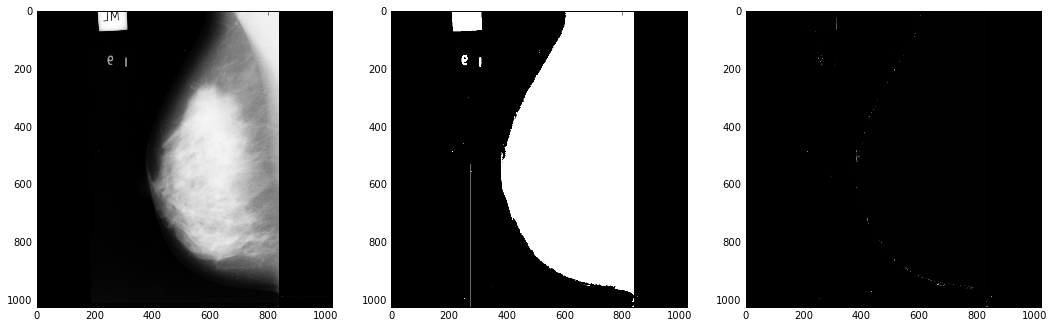

In [24]:
fig,axes = subplots(1, 3)
fig.set_size_inches([18, 6])
axes[0].imshow(img_norm, cmap='gray')
axes[1].imshow(th, cmap='gray')
axes[2].imshow(th_, cmap='gray')

In [25]:
cont_areas = [cv2.contourArea(c_) for c_ in contours]
np.argmax(cont_areas)

60

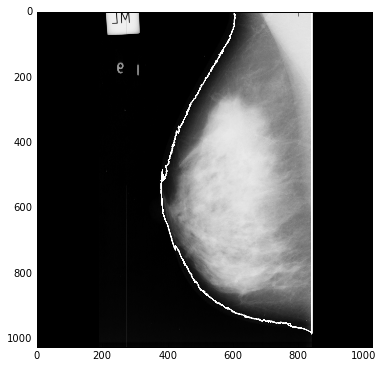

In [26]:
cont = cv2.drawContours(img_norm.copy(), contours, 60, (255,255,255), 3)
fig,ax = subplots()
fig.set_size_inches([6, 6])
ax.imshow(cont, cmap='gray')

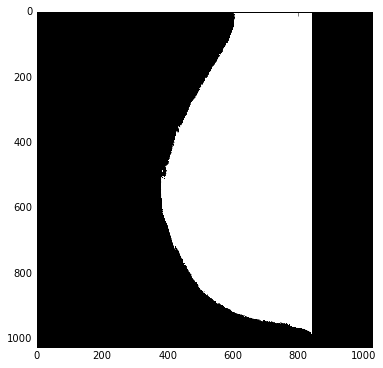

In [27]:
breast_mask = cv2.drawContours(np.zeros_like(th), contours, 60, 255, cv2.FILLED)
fig,ax = subplots()
fig.set_size_inches([6, 6])
ax.imshow(breast_mask, cmap='gray')

In [28]:
cv2.boundingRect(contours[60])

(378, 1, 460, 983)

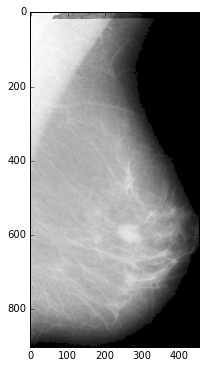

In [2]:
from dm_preprocess import DMImagePreprocessor as prep
img = cv2.imread('referenceData/MIAS/raw_data/mdb010.pgm', cv2.IMREAD_UNCHANGED)
img_breast = prep.segment_breast(img, .1)
fig,ax = subplots()
fig.set_size_inches([6, 6])
ax.imshow(img_breast, cmap='gray')

Using TensorFlow backend.


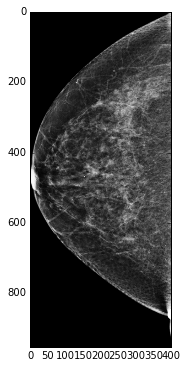

In [3]:
from dm_preprocess import DMImagePreprocessor as prep
from dm_image import read_resize_img
img = read_resize_img('trainingData/000135.dcm', target_height=1024, target_scale=4095)
img_breast = prep.segment_breast(img, .05)
fig,ax = subplots()
fig.set_size_inches([6, 6])
ax.imshow(img_breast, cmap='gray')

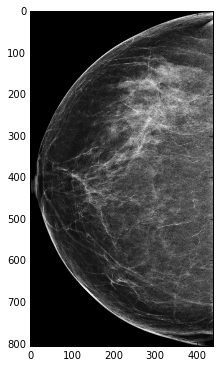

In [4]:
from dm_preprocess import DMImagePreprocessor as prep
from dm_image import read_resize_img
img = read_resize_img('trainingData/430458.dcm', target_height=1024, target_scale=4095)
img_breast = prep.segment_breast(img, .05)
fig,ax = subplots()
fig.set_size_inches([6, 6])
ax.imshow(img_breast, cmap='gray')

# Use blob detection to generate candidate ROIs

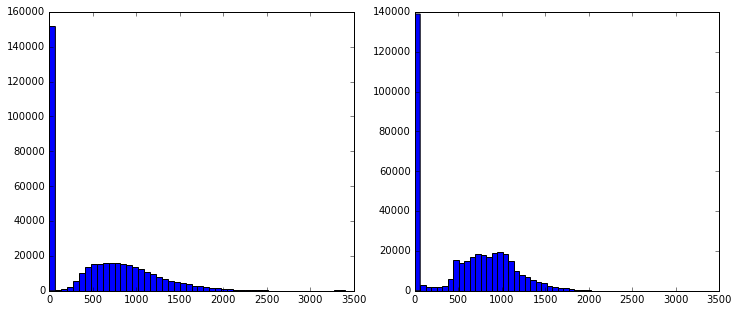

In [10]:
img_breast_blur = cv2.GaussianBlur(img_breast.copy(), (41, 41), 0)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 5])
_ = axes[0].hist(img_breast.ravel(), 50)
_ = axes[1].hist(img_breast_blur.ravel(), 50)

In [6]:
ret,th = cv2.threshold(img_breast, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print ret

error: /home/lishen/software/opencv/opencv_git_repo/modules/imgproc/src/thresh.cpp:1204: error: (-215) src.type() == CV_8UC1 in function threshold


tried to use Otsu thresholding to identify a cutoff automatically but it didn't seem to work.

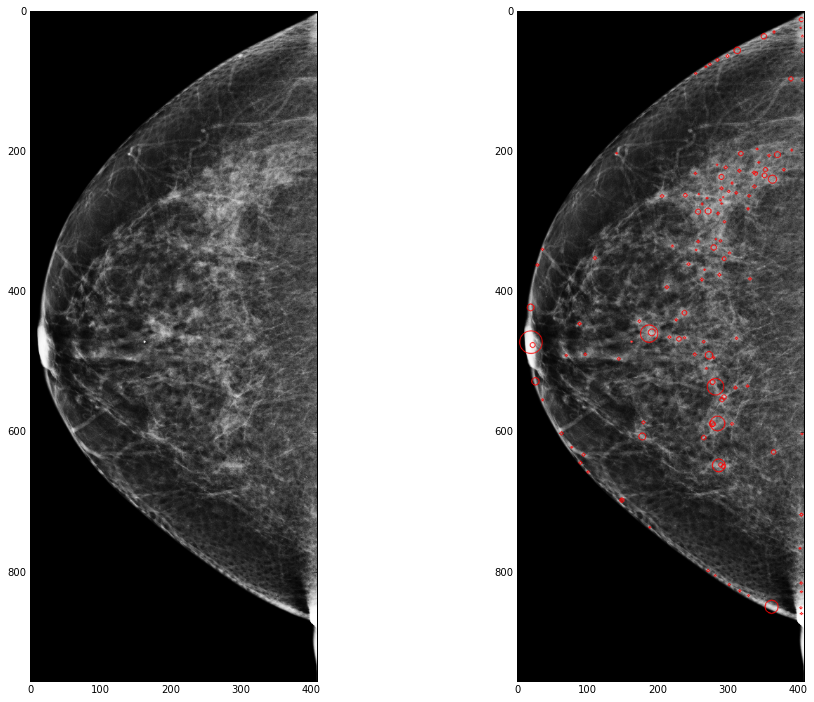

In [22]:
# Set up the detector with default parameters.
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 3
params.maxArea = 256**2
params.filterByCircularity = False
params.filterByColor = False
params.filterByConvexity = False
params.filterByInertia = False
params.minThreshold = 127
params.maxThreshold = 220
params.thresholdStep = 10
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
img_8u = (img_breast/img_breast.max()*255).astype('uint8')
keypoints = detector.detect(img_8u)
 
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle 
# corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(
    img_8u, keypoints, np.array([]), 255, 
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fig,axes = subplots(1, 2)
fig.set_size_inches([16, 12])
axes[0].imshow(img_8u, cmap='gray')
axes[1].imshow(im_with_keypoints, cmap='gray')

In [23]:
print len(keypoints)

130


In [8]:
kp = keypoints[0]
print kp.pt
print kp.size

(96.25, 718.25)
3.0


## Use blob detection to generate background image patches

In [107]:
from os import path
from dm_preprocess import DMImagePreprocessor as IMP
from numpy.random import RandomState

rng = RandomState(12345)
rs = 128  # ROI radius size.
bkg_cnt = 0
outdir = 'referenceData/MIAS/bkg'
low_th = .1
roi_th = .5
nb_sample = 16

params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 3
params.maxArea = (rs*2)**2
params.filterByCircularity = False
params.filterByColor = False
params.filterByConvexity = False
params.filterByInertia = False
params.minThreshold = int(roi_th*255)
params.maxThreshold = 220
params.thresholdStep = 10
detector = cv2.SimpleBlobDetector_create(params)

def clip(v, minv=0, maxv=1024):
    v = minv if v < minv else v
    v = maxv if v > maxv else v
    return v
    
for ref, info in img_info_df_indexed.iterrows():
    is_norm = info['Class'] == 'NORM'
    if not is_norm:
        continue
    img = cv2.imread(path.join('referenceData/MIAS', ref + '.pgm'), cv2.IMREAD_UNCHANGED)
    img = IMP.segment_breast(img, low_th)
    # Detect blobs.
    keypoints = detector.detect(img)
    if len(keypoints) > nb_sample:
        keypoints = rng.choice(keypoints, nb_sample, replace=False)
    for kp in keypoints:
        xc, yc = kp.pt
        x = xc - rs
        x = clip(x)
        y = yc - rs
        y = clip(y)
        roi = img[y:y+rs*2, x:x+rs*2]
        patch = np.zeros((rs*2, rs*2))
        patch[0:roi.shape[0], 0:roi.shape[1]] = roi
        fn = "%s_bkg%04d.png" % (ref, bkg_cnt)
        cv2.imwrite(path.join(outdir, fn), patch, [cv2.IMWRITE_PNG_COMPRESSION, 0])
        bkg_cnt += 1
print bkg_cnt

/Users/lishen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


3312


# Test ROI classifier on key points from mammograms

Using TensorFlow backend.


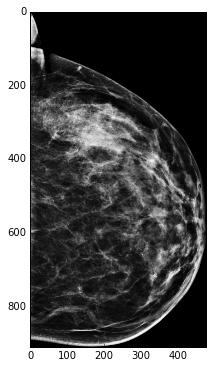

In [2]:
from dm_preprocess import DMImagePreprocessor as prep
from dm_image import read_resize_img
img = read_resize_img('preprocessedData/jpg_org/100152.jpg', 
                      target_height=1024, target_scale=4095)
img_breast = prep.segment_breast(img, .05)
fig,ax = subplots()
fig.set_size_inches([6, 6])
ax.imshow(img_breast, cmap='gray')

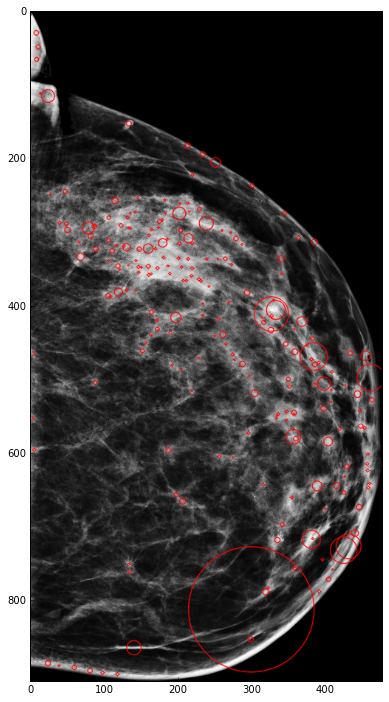

In [16]:
# Set up the detector with default parameters.
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 3
params.maxArea = 256**2
params.filterByCircularity = False
params.filterByColor = False
params.filterByConvexity = False
params.filterByInertia = False
params.minThreshold = 127
params.maxThreshold = 216
params.thresholdStep = 10
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
img_8u = (img_breast/img_breast.max()*255).astype('uint8')
keypoints = detector.detect(img_8u)
 
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle 
# corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(
    img_8u, keypoints, np.array([]), 255, 
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
fig,axes = subplots(1, 1)
fig.set_size_inches([8, 12])
# axes[0].imshow(img_8u, cmap='gray')
axes.imshow(im_with_keypoints, cmap='gray')

In [17]:
len(keypoints)

222

In [5]:
from numpy.random import RandomState
rng = RandomState()
keypoints_ = rng.choice(keypoints, 32, replace=False)

In [6]:
from dm_image import get_roi_patches
roi_patches = get_roi_patches(img_breast, keypoints_, (256,256))

In [7]:
roi_patches.shape

(32, 256, 256)

In [8]:
roi_patches = roi_patches.reshape((roi_patches.shape[0], roi_patches.shape[1], roi_patches.shape[2], 1))
roi_patches.shape

(32, 256, 256, 1)

In [9]:
pix_mean = 1042.79321289
pix_std = 772.12121582
roi_patches -= pix_mean
roi_patches /= pix_std

In [10]:
print roi_patches.mean()
print roi_patches.std()

0.0204355
1.15065


In [11]:
from keras.models import load_model
from dm_keras_ext import DMMetrics as dmm
roi_model = load_model('modelState/roi_clf4.h5', 
                       custom_objects={'sensitivity':dmm.sensitivity, 
                                       'specificity':dmm.specificity})

/Users/lishen/software/keras/keras/engine/topology.py:1799: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "model_1" was not an Input tensor, it was generated by layer dropout_1.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: input_1:0
  str(x.name))


IOError: decrementing file ID failed (Object atom: Unable to close file)

In [13]:
roi_prob = roi_model.predict(roi_patches, batch_size=1)
roi_prob.ravel()

array([ 0.24825753,  0.18257122,  0.33889779,  0.32115689,  0.45534283,
        0.92933488,  0.16888745,  0.82299984,  0.5824616 ,  0.16023898,
        0.08664653,  0.2644082 ,  0.13987201,  0.33550274,  0.11204174,
        0.32946572,  0.22469576,  0.93777966,  0.44600782,  0.78869551,
        0.96698171,  0.14927724,  0.21151939,  0.47179806,  0.15867177,
        0.35495427,  0.08054665,  0.77200705,  0.60006565,  0.48304412,
        0.46144232,  0.6653136 ], dtype=float32)

In [17]:
print np.argmax(roi_prob)
print np.argmin(roi_prob)
print keypoints[np.argmax(roi_prob)].pt
print keypoints[np.argmin(roi_prob)].pt

20
26
(188.63095092773438, 282.1626892089844)
(407.3690490722656, 530.7208862304688)


In [12]:
def show_kp_patch(img, x, y, roi_size=(256,256)):
    x1 = x - roi_size[1]/2
    y1 = y - roi_size[0]/2
    x2 = x + roi_size[1]/2
    y2 = y + roi_size[0]/2
    
    img_roi = cv2.rectangle(img.copy(), (x1, y1), (x2, y2), 4095, 2)
    fig,ax = subplots()
    fig.set_size_inches([9, 9])
    ax.imshow(img_roi, cmap='gray')

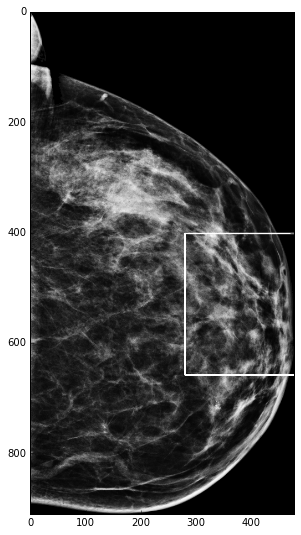

In [14]:
show_kp_patch(img_breast, 407, 530)

# Use K-means++ to cluster key points

In [20]:
xy_coord = [ [kp.pt[0], kp.pt[1]] for kp in keypoints ]
xy_coord = np.array(xy_coord)
print xy_coord.shape
print xy_coord[:5]

(222, 2)
[[  59.51716995  890.90447998]
 [ 140.16880798  864.30151367]
 [ 299.19372559  812.3581543 ]
 [ 298.13348389  852.42297363]
 [ 390.98602295  788.0267334 ]]


In [21]:
from sklearn.cluster import KMeans
clt = KMeans(32, init='k-means++', n_init=10, max_iter=30, random_state=12345)

In [23]:
clt.fit(xy_coord)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=30,
    n_clusters=32, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=12345, tol=0.0001, verbose=0)

In [26]:
print clt.cluster_centers_.shape
print clt.cluster_centers_[:5]

(32, 2)
[[ 343.43912853  558.53778631]
 [ 132.63028412  280.94815826]
 [  40.68035444  888.29243978]
 [ 401.49757996  742.1034668 ]
 [ 252.25269209  422.62320382]]


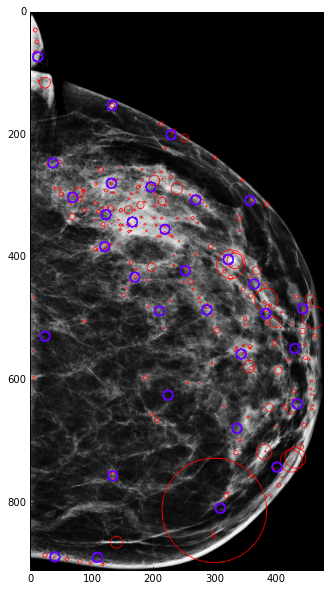

In [35]:
# key points.
img_8u = (img_breast/img_breast.max()*255).astype('uint8')
im_with_keypoints = cv2.drawKeypoints(
    img_8u, keypoints, np.array([]), 255, 
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# add k-means centroids.
for cen in clt.cluster_centers_:
    cv2.circle(im_with_keypoints, (int(cen[0]), int(cen[1])), 8, (100,0,255), 2)
fig,axes = subplots(1, 1)
fig.set_size_inches([6, 10])
# axes[0].imshow(img_8u, cmap='gray')
axes.imshow(im_with_keypoints, cmap='gray')

## Test on a mammogram with pectoral muscle region

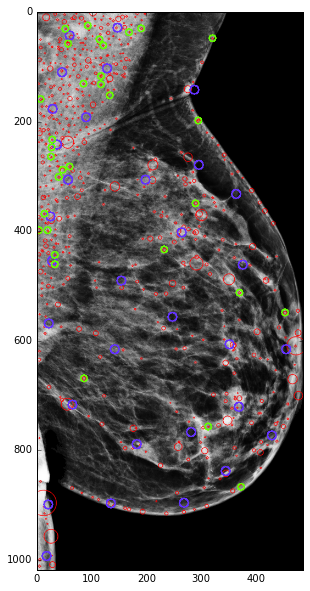

In [49]:
img = read_resize_img('preprocessedData/jpg_org/100153.jpg', 
                      target_height=1024, target_scale=4095)
img_breast = prep.segment_breast(img, .05)

# Set up the detector with default parameters.
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 3
params.maxArea = 256**2
params.filterByCircularity = False
params.filterByColor = False
params.filterByConvexity = False
params.filterByInertia = False
params.minThreshold = 127
params.maxThreshold = 216
params.thresholdStep = 10
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
img_8u = (img_breast/img_breast.max()*255).astype('uint8')
keypoints = detector.detect(img_8u)
xy_coord = [ [kp.pt[0], kp.pt[1]] for kp in keypoints ]
xy_coord = np.array(xy_coord)

# K-means.
from sklearn.cluster import KMeans
clt = KMeans(32, init='k-means++', n_init=10, max_iter=30, random_state=12345)
clt.fit(xy_coord)

# Random sampling.
kp_subset = rng.choice(keypoints, 32, replace=False)
sub_coord = [ [int(kp.pt[0]), int(kp.pt[1])] for kp in kp_subset ]
sub_coord = np.array(sub_coord)

# Draw key points.
im_with_keypoints = cv2.drawKeypoints(
    img_8u, keypoints, np.array([]), 255, 
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# add k-means centroids.
for cen in clt.cluster_centers_:
    cv2.circle(im_with_keypoints, (int(cen[0]), int(cen[1])), 8, (100,50,255), 2)
    
# add random samples.
for x,y in sub_coord:
    cv2.circle(im_with_keypoints, (x,y), 6, (100,255,0), 2)

# plot.
fig,axes = subplots(1, 1)
fig.set_size_inches([6, 10])
# axes[0].imshow(img_8u, cmap='gray')
axes.imshow(im_with_keypoints, cmap='gray')